In [1]:
import QuantLib as ql
import math
import numpy as np

In [12]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate

class bond_price_cal_:

    def __init__(self, t, all_equity_num, issue_date, first_coupon_date, first_dividend_date, face_value, S_0, r, q, credit_risk, T, N, D, delta, maturity_prem, call_provision, if_soft_call, if_soft_put, method, put_provision, put_start_date, coupon_rate, X, conversation_start_date, path_num):
        """
        issue_date, first_dividend_date, face_value, S_0, r, q, T, N, 
        D 分红, 
        delta, 
        maturity_prem 如果持有到期末的premium, 
        call_provision, if_soft_call, if_soft_put, method, put_provision, put_start_year, 
        coupon_rate, 
        X 执行价, 
        no_con_time 没有赎回的days, no_call_time 没有回售的days, 
        path_num monte carlo模拟的path数
        """
        calendar = ql.China()
        day_count = ql.Actual365Fixed()
        end_of_month = True
        self.t = t
        self.all_equity_num = all_equity_num
        self.issue_date = issue_date
        self.maturity_date = calendar.advance(
            issue_date, ql.Period(int(T), ql.Days))
        self.first_dividend_date = first_dividend_date
        self.first_coupon_date = first_coupon_date
        self.face_value = face_value
        self.S_0 = S_0
        self.T = T
        self.occured_time = day_count.yearFraction(issue_date, t)
        #print(self.occured_time, day_count.dayCount(issue_date, t))
        self.delta_t = day_count.yearFraction(self.t, self.maturity_date)/N
        self.r = r
        self.q = q
        self.credit_risk = credit_risk
        self.N = N
        self.D = D
        self.u = math.exp(math.sqrt((delta**2-credit_risk)*self.delta_t))
        self.d = 1/self.u
        #print(self.u,self.d)
        self.delta = delta
        self.maturity_prem = maturity_prem
        self.mu = r-q-delta**2/2
        self.if_soft_call = if_soft_call
        self.if_soft_put = if_soft_put
        self.method = method
        self.Mc = call_provision
        self.Mp = put_provision
        self.X = X
        self.a = math.exp((r-q)*self.delta_t)
        self.recovery = 40
        self.put_start_date = put_start_date
        self.conversation_start_date = conversation_start_date
        self.coupon_rate = coupon_rate
        self.path_num = path_num      
        print('---------------------basic information-----------------')
        print('dt:', self.delta_t)
        print('the bond start at %s, end at %s'%(self.issue_date,self.maturity_date))
        print('the dividend is %.2f'%(self.D))
        print('the volatility of stock:', self.delta)
        print('the risk-free rate', self.r)
        print('coupon_rate:', self.coupon_rate)
        print('maturity Premium:', self.maturity_prem)
        if all_equity_num == 0:
            print('no dilution mode')
        else:
            print('dilution applied')
        self.pu = (self.a-self.d*math.exp(-credit_risk*self.delta_t)) / \
            (self.u-self.d)
        self.pd = (self.u*math.exp(-credit_risk*self.delta_t)-self.a) / \
            (self.u-self.d)
        self.p_default = 1-math.exp(-credit_risk*self.delta_t)
        #print(self.pu,self.pd,self.p_default)
#         print('put provision start at %s th year'%(self.put_start_year))
#         fig, ax = plt.subplots(figsize=(12, 10))
#         ax.set_title('S0 = %.2f, r = %.2f, sigma = %.2f, simulation number = %.f ' %(self.S_0,self.r,self.delta,self.path_num), fontsize=12)
        # create list of daily returns using random normal distribution
        self.price_list_all = []
        for i in range(self.path_num):
            daily_returns = np.random.normal(
                (self.mu/self.T), self.delta/math.sqrt(self.T), self.T)+1
            # set starting price and create price series generated by above random daily returns
            price_list = [self.S_0]
            for x in daily_returns:
                price_list.append(price_list[-1]*x)
            self.price_list_all.append(price_list)
            # Generate Plots - price series and histogram of daily returns
#             ax.plot(price_list)
#         plt.show()
    
    def gen_call_bar(self):
        if self.if_soft_call == True:
            if self.method == 'Bloomberg':
                count = 0
                for path_id in range(self.path_num):
                    for t in range(30, self.T):
                        temp = self.price_list_all[path_id][t-30:t]
                        k = len([i for i in temp if i > 1.2*self.X]) 
                        if k >= 15:
                            count += 1
                            break
                prob = count/self.path_num
                max_path = pd.Series([max(path)
                                      for path in self.price_list_all])
                Hbar = max_path.quantile([1-prob]).values
                print('Hbar:', Hbar)
                return Hbar*(self.face_value/self.X)
        else:
            return self.Mc

    def gen_put_bar(self):
        if self.if_soft_put == True:
            count = 0
            for path_id in range(self.path_num):
                for t in range(30, self.T):
                    temp = self.price_list_all[path_id][t-30:t]
                    k = len([i for i in temp if i < 0.7*self.X])
                    if k >= 30:
                        count += 1
                        break
            prob = count/self.path_num
            min_path = pd.Series([min(path) for path in self.price_list_all])
            Hbar = min_path.quantile([prob]).values
            print('Hbar:', Hbar)
            return Hbar*(self.face_value/self.X)
        else:
            return self.Mp

    def cal_vest_period(self):
        calendar = ql.China()
        day_count = ql.Actual365Fixed()
        if self.t < self.conversation_start_date:
            no_con_yf = day_count.yearFraction(
                self.t, self.conversation_start_date)
        else:
            no_con_yf = 0
        x_n = math.floor(no_con_yf/self.delta_t)
        
        if self.t < self.put_start_date:
            no_put_yf = day_count.yearFraction(self.t,self.put_start_date)
        else:
            no_put_yf = 0
        y_n = math.floor(no_put_yf/self.delta_t)
        return x_n, y_n

    def coupon_cal(self):
        calendar = ql.China()
        day_count = ql.Actual365Fixed()
        coupon_date = [calendar.advance(self.first_coupon_date, ql.Period(
            i, ql.Years)) for i in range(1, int(self.T/252)+1)]
        # print(coupon_date)
        coupon_yf_list = []
        for d in coupon_date:
            if self.t < d and d <= self.maturity_date:
                yf = day_count.yearFraction(self.t, d)
                coupon_yf_list.append(yf)
        # print(coupon_yf_list)
        node_approx = [int(np.floor(yf/self.delta_t)) for yf in coupon_yf_list]
        #print('pay dividend at these nodes:',node_approx)
        return node_approx

#         coupon_payment = [cr * self.face_value for cr in self.coupon_rate]
#         print(coupon_payment)
#         return coupon_payment

    def dividend_cal(self):
        calendar = ql.China()
        fixedPaymentConvention = ql.ModifiedFollowing
        bussiness_convention = ql.Unadjusted
        day_count = ql.Actual365Fixed()
        end_of_month = True
        dividend_date = [calendar.advance(self.first_dividend_date, ql.Period(
            i, ql.Years)) for i in range(0, int(self.T/252))]
        # print(dividend_date)
        dividend_yf_list = []
        for d in dividend_date:
            if self.t < d and d <= self.maturity_date:
                yf = day_count.yearFraction(self.t, d)
            # if d <= self.maturity_date:
                dividend_yf_list.append(yf)
        # print(dividend_yf_list)
        node_approx = [int(np.floor(yf/self.delta_t))
                       for yf in dividend_yf_list]
        #print('pay dividend at these nodes:',node_approx)
        return len(node_approx), node_approx
    

    def check_remain_share(self,dt):
        calendar = ql.China()
        day_count = ql.Actual365Fixed()
        share_check_date = [calendar.advance(self.conversation_start_date,ql.Period(3*i,ql.Months)) for i in range(0,10)]
        remain_share = [3e6,2.999e6,2.998e6,2.998e6,2.998e6,2.998e6,2.998e6,2.998e6,2.997e6,2.994e6]
        share_check_yf = [day_count.yearFraction(self.conversation_start_date,d) for d in share_check_date]
        f = interpolate.interp1d(share_check_yf, remain_share, kind="slinear")
        try:  
            return 3e6- f(dt)
        except:
            return (3e6-2.994e6)+dt*3*1e5
    
    def exchangable_bond(self):
        calendar = ql.China()
        day_count = ql.Actual365Fixed()
        Mc = self.gen_call_bar()
        print('the call boundary is %.2f' % (Mc))
        Mp = self.gen_put_bar()
        print('the put boundary is %.2f' % (Mp))
        x_n, y_n = self.cal_vest_period()
        print('There is no conversation before %.f node and no put provision before %.f node ' % (
            x_n, y_n))
        node_approx_coupon = self.coupon_cal()
        print('pay coupon at these nodes:', node_approx_coupon)
        dividend_times, node_approx_dividend = self.dividend_cal()
        print('pay dividend at these nodes:', node_approx_dividend)
        V = np.zeros((self.N+1, self.N+1))
        Q = np.zeros((self.N+1, self.N+1))
        coupon_NPV = [cr * self.face_value for cr in self.coupon_rate]
        print('paid %.2f at maturity:' % (coupon_NPV[-1]))
        self.X -= dividend_times * self.D
        for j in range(self.N+1):
            V[j, self.N] = max(self.S_0*(self.u**(2*j-self.N)),
                               0) - dividend_times * self.D
            Q[j, self.N] = max((self.face_value + coupon_NPV[-1])*self.maturity_prem,
                               (self.face_value/self.X) * V[j, self.N])
        for n in range(self.N-1, -1, -1):
            temp_coupon = 0
            temp_dividend = 0
            print('back loop to %d node' % (n))

            if n >= y_n and n >= x_n:
                print('put provision start, conversation permitted')
                if n in node_approx_coupon:
                    temp_coupon = coupon_NPV[int(
                        self.occured_time + self.delta_t * n)-1]
                    print('%.2f coupon paied at %.2f year ' %
                          (temp_coupon, self.delta_t * n))
                if n in node_approx_dividend:
                    temp_dividend = self.D
                    self.X += temp_dividend
                    print('%.2f dividend occured at %.2f year, the conversation ratio changed to %.4f ' % (
                        temp_dividend, self.delta_t * n, self.face_value/self.X))
                if self.all_equity_num == 0:
                    dilution_factor = 1 
                else:
                    time_to_con = day_count.yearFraction(self.conversation_start_date,calendar.advance(self.t,ql.Period(int(self.delta_t * n*252),ql.Days)))
                    dilution_factor = self.all_equity_num/(self.all_equity_num + self.check_remain_share(time_to_con) * self.face_value/self.X)
                    print('%.2f shares already be converted, dilution factor is %.2f'%(self.check_remain_share(time_to_con),dilution_factor))
                for k in range(n+1):
                    V[k, n] = math.exp(-self.r*self.delta_t) * \
                        (self.pu*V[k+1, n+1]+self.pd * V[k, n+1]) + temp_dividend
                    rollback = math.exp(-self.r*self.delta_t)*(
                        self.pu * Q[k+1, n+1]+self.pd*Q[k, n+1]+self.p_default*self.recovery) + temp_coupon
                    Q[k, n] = max(min(rollback, Mc), Mp,
                                  (self.face_value/self.X)*V[k, n]*dilution_factor)

            if n < x_n and n < y_n:
                print('no conversation and no put provision')
                if n in node_approx_coupon:
                    temp_coupon = coupon_NPV[int(
                        self.occured_time + self.delta_t * n)-1]
                    print('%.2f coupon paied at %.2f year ' %
                          (temp_coupon, self.delta_t * n))
                if n in node_approx_dividend:
                    temp_dividend = self.D
                    self.X += temp_dividend
                    print('%.2f dividend occured at %.2f year, the conversation ratio changed to %.4f ' % (
                        temp_dividend, self.delta_t * n, self.face_value/self.X))
                for k in range(n+1):
                    V[k, n] = math.exp(-self.r*self.delta_t) * \
                        (self.pu*V[k+1, n+1]+self.pd * V[k, n+1]) + temp_dividend
                    rollback = math.exp(-self.r*self.delta_t)*(
                        self.pu * Q[k+1, n+1]+self.pd*Q[k, n+1]+self.p_default*self.recovery) + temp_coupon
                    Q[k, n] = min(rollback, Mc)
                    
            if n < x_n and n >= y_n:
                print('no conversation but has put provision')
                if n in node_approx_coupon:
                    temp_coupon = coupon_NPV[int(
                        self.occured_time + self.delta_t * n)-1]
                    print('%.2f coupon paied at %.2f year ' %
                          (temp_coupon, self.delta_t * n))
                if n in node_approx_dividend:
                    temp_dividend = self.D
                    self.X += temp_dividend
                    print('%.2f dividend occured at %.2f year, the conversation ratio changed to %.4f ' % (
                        temp_dividend, self.delta_t * n, self.face_value/self.X))
                for k in range(n+1):
                    V[k, n] = math.exp(-self.r*self.delta_t) * \
                        (self.pu*V[k+1, n+1]+self.pd * V[k, n+1]) + temp_dividend
                    rollback = math.exp(-self.r*self.delta_t)*(
                        self.pu * Q[k+1, n+1]+self.pd*Q[k, n+1]+self.p_default*self.recovery) + temp_coupon
                    Q[k, n] = max(min(rollback, Mc), Mp)   
                    
            if n >= x_n and n < y_n:
                print('conversation permitted but no put provision')
                if self.all_equity_num == 0:
                    dilution_factor = 1 
                else:
                    time_to_con = day_count.yearFraction(self.conversation_start_date,calendar.advance(self.t,ql.Period(int(self.delta_t * n*252),ql.Days)))
                    dilution_factor = self.all_equity_num/(self.all_equity_num +self.check_remain_share(time_to_con) * self.face_value/self.X)
                print('dilution factor is %.2f'%(dilution_factor))
                if n in node_approx_coupon:
                    temp_coupon = coupon_NPV[int(
                        self.occured_time + self.delta_t * n)-1]
                    print('%.2f coupon paied at %.2f year ' %
                          (temp_coupon, self.delta_t * n))
                if n in node_approx_dividend:
                    temp_dividend = self.D
                    self.X += temp_dividend
                    print('%.2f dividend occured at %.2f year, the conversation ratio changed to %.4f ' % (
                        temp_dividend, self.delta_t * n, self.face_value/self.X))
                for k in range(n+1):
                    V[k, n] = math.exp(-self.r*self.delta_t) * \
                        (self.pu*V[k+1, n+1]+self.pd * V[k, n+1]) + temp_dividend
                    rollback = math.exp(-self.r*self.delta_t)*(
                        self.pu * Q[k+1, n+1]+self.pd*Q[k, n+1]+self.p_default*self.recovery) + temp_coupon
                    Q[k, n] = max(min(rollback, Mc),(self.face_value/self.X)*V[k, n]*dilution_factor)

        print('The price of exchangeable bond is ' + str(round(Q[0, 0], 4)))
        return Q[0, 0]

## Exchangeable bond 

In [3]:
#stock_data = pd.read_csv('sh132018.csv')

adjclose =[21.92,21.81,21.72,21.48,21.50,21.75,21.98,21.83,21.73,22.00,22.18,21.61,21.81,22.63,22.35,22.96,23.11,23.64,23.91,23.85,23.75,23.44,23.22,23.030,22.660,22.660,22.710,22.760,22.770,22.780]
#list(stock_data['Open'])[-30:]
#date_cal = stock_data['Date']
calendar = ql.China()
Date_list = [calendar.advance(ql.Date(22,2,2022),ql.Period(i,ql.Days)) for i in range(0,28)] 

[Date(22,2,2022),
 Date(23,2,2022),
 Date(24,2,2022),
 Date(25,2,2022),
 Date(28,2,2022),
 Date(1,3,2022),
 Date(2,3,2022),
 Date(3,3,2022),
 Date(4,3,2022),
 Date(7,3,2022),
 Date(8,3,2022),
 Date(9,3,2022),
 Date(10,3,2022),
 Date(11,3,2022),
 Date(14,3,2022),
 Date(15,3,2022),
 Date(16,3,2022),
 Date(17,3,2022),
 Date(18,3,2022),
 Date(21,3,2022),
 Date(22,3,2022),
 Date(23,3,2022),
 Date(24,3,2022),
 Date(25,3,2022),
 Date(28,3,2022),
 Date(29,3,2022),
 Date(30,3,2022),
 Date(31,3,2022)]

In [4]:
price_list_1 = []
for i in range(0,28):
    stock_price = adjclose[i]
    calc_date = Date_list[i]
    print(calc_date)
    print(stock_price)
    test1 = bond_price_cal_(calc_date,0,ql.Date(9,4,2019),ql.Date(9,4,2019),ql.Date(13,7,2020), 100, stock_price, 0.05, 0.0, 0.01, 252*5, 30, 0.068, 
                        0.5372, 1.08, 120, True, True,'Bloomberg', 70, ql.Date(9,4,2023), [0.005, 0.005, 0.005,0.0005,0.005], 
                        16.74, ql.Date(4,9,2020), 1000)
    bond_price_1 = test1.exchangable_bond()
    price_list_1.append(bond_price_1)

February 22nd, 2022
21.92
---------------------basic information-----------------
dt: 0.07123287671232877
the bond start at April 9th, 2019, end at April 12th, 2024
the dividend is 0.07
the volatility of stock: 0.5372
the risk-free rate 0.05
coupon_rate: [0.005, 0.005, 0.005, 0.0005, 0.005]
maturity Premium: 1.08
no dilution mode
Hbar: [21.92]
the call boundary is 130.94
Hbar: [10.80949971]
the put boundary is 64.57
There is no conversation before 0 node and no put provision before 15 node 
pay coupon at these nodes: [1, 15, 29]
pay dividend at these nodes: [5, 19]
paid 0.50 at maturity:
back loop to 29 node
put provision start, conversation permitted
0.05 coupon paied at 2.07 year 
back loop to 28 node
put provision start, conversation permitted
back loop to 27 node
put provision start, conversation permitted
back loop to 26 node
put provision start, conversation permitted
back loop to 25 node
put provision start, conversation permitted
back loop to 24 node
put provision start, conver

Hbar: [21.48]
the call boundary is 128.32
Hbar: [10.69712932]
the put boundary is 63.90
There is no conversation before 0 node and no put provision before 15 node 
pay coupon at these nodes: [1, 15, 29]
pay dividend at these nodes: [5, 19]
paid 0.50 at maturity:
back loop to 29 node
put provision start, conversation permitted
0.05 coupon paied at 2.06 year 
back loop to 28 node
put provision start, conversation permitted
back loop to 27 node
put provision start, conversation permitted
back loop to 26 node
put provision start, conversation permitted
back loop to 25 node
put provision start, conversation permitted
back loop to 24 node
put provision start, conversation permitted
back loop to 23 node
put provision start, conversation permitted
back loop to 22 node
put provision start, conversation permitted
back loop to 21 node
put provision start, conversation permitted
back loop to 20 node
put provision start, conversation permitted
back loop to 19 node
put provision start, conversation 

Hbar: [21.98]
the call boundary is 131.30
Hbar: [10.6143414]
the put boundary is 63.41
There is no conversation before 0 node and no put provision before 15 node 
pay coupon at these nodes: [1, 15, 29]
pay dividend at these nodes: [5, 19]
paid 0.50 at maturity:
back loop to 29 node
put provision start, conversation permitted
0.05 coupon paied at 2.04 year 
back loop to 28 node
put provision start, conversation permitted
back loop to 27 node
put provision start, conversation permitted
back loop to 26 node
put provision start, conversation permitted
back loop to 25 node
put provision start, conversation permitted
back loop to 24 node
put provision start, conversation permitted
back loop to 23 node
put provision start, conversation permitted
back loop to 22 node
put provision start, conversation permitted
back loop to 21 node
put provision start, conversation permitted
back loop to 20 node
put provision start, conversation permitted
back loop to 19 node
put provision start, conversation p

Hbar: [22.]
the call boundary is 131.42
Hbar: [10.76074328]
the put boundary is 64.28
There is no conversation before 0 node and no put provision before 15 node 
pay coupon at these nodes: [1, 15, 29]
pay dividend at these nodes: [5, 19]
paid 0.50 at maturity:
back loop to 29 node
put provision start, conversation permitted
0.05 coupon paied at 2.03 year 
back loop to 28 node
put provision start, conversation permitted
back loop to 27 node
put provision start, conversation permitted
back loop to 26 node
put provision start, conversation permitted
back loop to 25 node
put provision start, conversation permitted
back loop to 24 node
put provision start, conversation permitted
back loop to 23 node
put provision start, conversation permitted
back loop to 22 node
put provision start, conversation permitted
back loop to 21 node
put provision start, conversation permitted
back loop to 20 node
put provision start, conversation permitted
back loop to 19 node
put provision start, conversation pe

Hbar: [21.81]
the call boundary is 130.29
Hbar: [10.73866491]
the put boundary is 64.15
There is no conversation before 0 node and no put provision before 15 node 
pay coupon at these nodes: [1, 15, 29]
pay dividend at these nodes: [4, 19]
paid 0.50 at maturity:
back loop to 29 node
put provision start, conversation permitted
0.05 coupon paied at 2.02 year 
back loop to 28 node
put provision start, conversation permitted
back loop to 27 node
put provision start, conversation permitted
back loop to 26 node
put provision start, conversation permitted
back loop to 25 node
put provision start, conversation permitted
back loop to 24 node
put provision start, conversation permitted
back loop to 23 node
put provision start, conversation permitted
back loop to 22 node
put provision start, conversation permitted
back loop to 21 node
put provision start, conversation permitted
back loop to 20 node
put provision start, conversation permitted
back loop to 19 node
put provision start, conversation 

Hbar: [22.96]
the call boundary is 137.16
Hbar: [10.64503848]
the put boundary is 63.59
There is no conversation before 0 node and no put provision before 15 node 
pay coupon at these nodes: [1, 15, 29]
pay dividend at these nodes: [4, 19]
paid 0.50 at maturity:
back loop to 29 node
put provision start, conversation permitted
0.05 coupon paied at 2.01 year 
back loop to 28 node
put provision start, conversation permitted
back loop to 27 node
put provision start, conversation permitted
back loop to 26 node
put provision start, conversation permitted
back loop to 25 node
put provision start, conversation permitted
back loop to 24 node
put provision start, conversation permitted
back loop to 23 node
put provision start, conversation permitted
back loop to 22 node
put provision start, conversation permitted
back loop to 21 node
put provision start, conversation permitted
back loop to 20 node
put provision start, conversation permitted
back loop to 19 node
put provision start, conversation 

Hbar: [23.91]
the call boundary is 142.83
Hbar: [10.73992778]
the put boundary is 64.16
There is no conversation before 0 node and no put provision before 15 node 
pay coupon at these nodes: [0, 15, 29]
pay dividend at these nodes: [4, 19]
paid 0.50 at maturity:
back loop to 29 node
put provision start, conversation permitted
0.05 coupon paied at 2.00 year 
back loop to 28 node
put provision start, conversation permitted
back loop to 27 node
put provision start, conversation permitted
back loop to 26 node
put provision start, conversation permitted
back loop to 25 node
put provision start, conversation permitted
back loop to 24 node
put provision start, conversation permitted
back loop to 23 node
put provision start, conversation permitted
back loop to 22 node
put provision start, conversation permitted
back loop to 21 node
put provision start, conversation permitted
back loop to 20 node
put provision start, conversation permitted
back loop to 19 node
put provision start, conversation 

Hbar: [23.44]
the call boundary is 140.02
Hbar: [10.70982926]
the put boundary is 63.98
There is no conversation before 0 node and no put provision before 15 node 
pay coupon at these nodes: [0, 15, 29]
pay dividend at these nodes: [4, 19]
paid 0.50 at maturity:
back loop to 29 node
put provision start, conversation permitted
0.05 coupon paied at 1.99 year 
back loop to 28 node
put provision start, conversation permitted
back loop to 27 node
put provision start, conversation permitted
back loop to 26 node
put provision start, conversation permitted
back loop to 25 node
put provision start, conversation permitted
back loop to 24 node
put provision start, conversation permitted
back loop to 23 node
put provision start, conversation permitted
back loop to 22 node
put provision start, conversation permitted
back loop to 21 node
put provision start, conversation permitted
back loop to 20 node
put provision start, conversation permitted
back loop to 19 node
put provision start, conversation 

Hbar: [22.66]
the call boundary is 135.36
Hbar: [10.65224772]
the put boundary is 63.63
There is no conversation before 0 node and no put provision before 15 node 
pay coupon at these nodes: [0, 15, 29]
pay dividend at these nodes: [4, 18]
paid 0.50 at maturity:
back loop to 29 node
put provision start, conversation permitted
0.05 coupon paied at 1.98 year 
back loop to 28 node
put provision start, conversation permitted
back loop to 27 node
put provision start, conversation permitted
back loop to 26 node
put provision start, conversation permitted
back loop to 25 node
put provision start, conversation permitted
back loop to 24 node
put provision start, conversation permitted
back loop to 23 node
put provision start, conversation permitted
back loop to 22 node
put provision start, conversation permitted
back loop to 21 node
put provision start, conversation permitted
back loop to 20 node
put provision start, conversation permitted
back loop to 19 node
put provision start, conversation 

Hbar: [22.76]
the call boundary is 135.96
Hbar: [10.70308831]
the put boundary is 63.94
There is no conversation before 0 node and no put provision before 15 node 
pay coupon at these nodes: [0, 15, 29]
pay dividend at these nodes: [4, 18]
paid 0.50 at maturity:
back loop to 29 node
put provision start, conversation permitted
0.05 coupon paied at 1.97 year 
back loop to 28 node
put provision start, conversation permitted
back loop to 27 node
put provision start, conversation permitted
back loop to 26 node
put provision start, conversation permitted
back loop to 25 node
put provision start, conversation permitted
back loop to 24 node
put provision start, conversation permitted
back loop to 23 node
put provision start, conversation permitted
back loop to 22 node
put provision start, conversation permitted
back loop to 21 node
put provision start, conversation permitted
back loop to 20 node
put provision start, conversation permitted
back loop to 19 node
put provision start, conversation 

In [5]:
ori_ex_price=[131.44,130.54,129.87,129.25,130.03,131.66,133.38,131.41,131.09,131.57,132.60,129.28,130.66,134.70,133.58,136.58,137.43,140.38,143.01,143.73,143.10,142.24,140.92,139.65,139.17,
138.96,139.25,139.76]
Stockprice=adjclose

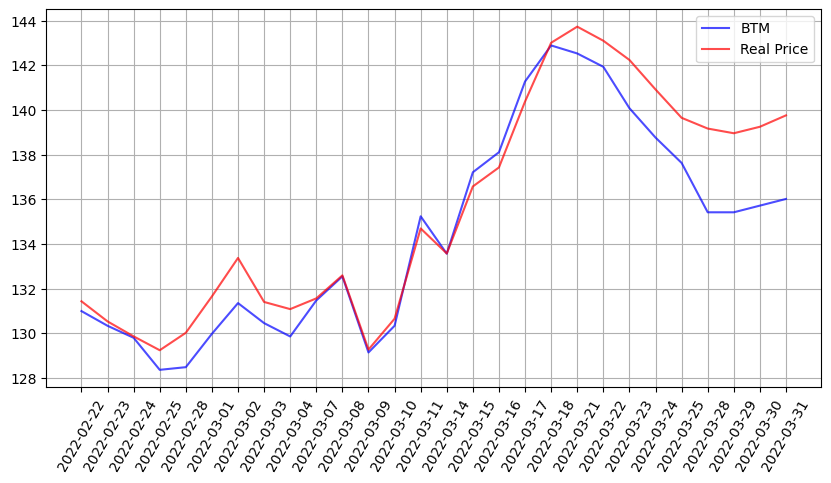

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
fig = plt.figure(figsize=(10, 5), dpi=100)
ax = fig.add_subplot(111)
date_xtick = ['2022-02-22','2022-02-23', '2022-02-24','2022-02-25','2022-02-28','2022-03-01', '2022-03-02', '2022-03-03',
              '2022-03-04', '2022-03-07', '2022-03-08', '2022-03-09', '2022-03-10', '2022-03-11',
              '2022-03-14', '2022-03-15','2022-03-16', '2022-03-17', '2022-03-18', '2022-03-21', '2022-03-22', '2022-03-23',
              '2022-03-24', '2022-03-25',  '2022-03-28', '2022-03-29', '2022-03-30', '2022-03-31']
#adjclose_conv = [a*100/18.8 for a in list(stock_data['Close'])[-30:-2]]
adjclose_conv = [a*100/16.74 for a in list(Stockprice)[-30:-2]]
plt.xticks(rotation=60)
ax.plot(date_xtick, price_list_1, color='b',label = 'BTM',alpha = 0.7)
#ax.plot(date_xtick, price_list_2, color='g',label = 'BTM with Dilution')
#ax.plot(date_xtick,adjclose_conv, color='y',label = 'Conversation Value',alpha = 0.7)
ax.plot(date_xtick,ori_ex_price, color='r',label = 'Real Price',alpha = 0.7)
plt.legend()
plt.grid()
plt.show()